# Setup

In [1]:
%matplotlib inline

import numpy as np
import scipy.signal as sig
import scipy.stats as stat
import matplotlib.pyplot as plt
import seaborn as sns
import os
import h5py
import pandas as pd
import resin

from pandas import DataFrame,Series,read_table

General info

In [2]:
savePlots = True    # whether or not to save plots
saveData = True # whether or not to save csv files

saveAsPath = './Fig 09/'
if not os.path.exists(saveAsPath):
    os.mkdir(saveAsPath)

saveAsName = 'Fig9'

In [3]:
#path = '/Users/svcanavan/Dropbox/Coding in progress/00_BudgieSleep/Data_copies/'

birdPaths =    ['../data_copies/01_PreprocessedData/01_BudgieFemale_green1/00_Baseline_night/',
                '../data_copies/01_PreprocessedData/02_BudgieMale_yellow1/00_Baseline_night/',
                '../data_copies/01_PreprocessedData/03_BudgieFemale_white1/00_Baseline_night/',
                '../data_copies/01_PreprocessedData/04_BudgieMale_yellow2/00_Baseline_night/',
                '../data_copies/01_PreprocessedData/05_BudgieFemale_green2/00_Baseline_night/']

arfFilePaths =  ['EEG 2 scored/',
                 'EEG 3 scored/',
                 'EEG 3 scored/',
                 'EEG 4 scored/',
                 'EEG 4 scored/']

### load BEST EEG channels - as determined during manual scoring ####
channelsToLoadEEG_best = [['6 LEEGm-LEEGp', '5 LEEGf-LEEGp'], #, '9 REEGp-LEEGp'], # extra channel to represent R hemisphere
                     ['5 LEEGf-LEEGm', '4 LEEGf-Fgr'], #, '9 REEGf-REEGm'], # extra channel to represent R hemisphere
                     ['9REEGm-REEGp', '4LEEGf-LEEGp'], 
                     ['6LEEGm-LEEGf', '9REEGf-REEGp'], 
                     ['7REEGf-REEGp', '4LEEGf-LEEGp']]


### load ALL of EEG channels ####
channelsToLoadEEG = [['4 LEEGf-Fgr', '5 LEEGf-LEEGp', '6 LEEGm-LEEGp', '7 LEEGp-Fgr', '8 REEGp-Fgr','9 REEGp-LEEGp'],
                     ['4 LEEGf-Fgr','5 LEEGf-LEEGm', '6 LEEGm-LEEGp', '7 REEGf-Fgr', '8 REEGm-Fgr', '9 REEGf-REEGm'],
                     ['4LEEGf-LEEGp', '5LEEGf-LEEGm', '6LEEGm-LEEGp', '7REEGf-REEGp', '8REEGf-REEGm', '9REEGm-REEGp'],
                     ['4LEEGf-LEEGp', '5LEEGm-LEEGp', '6LEEGm-LEEGf', '7REEGf-Fgr', '8REEGf-REEGm','9REEGf-REEGp',],
                     ['4LEEGf-LEEGp', '5LEEGf-LEEGm', '6LEEGm-LEEGp', '7REEGf-REEGp', '8REEGf-REEGm', '9REEGm-REEGp']]


channelsToLoadEOG = [['1 LEOG-Fgr', '2 REOG-Fgr'],
                     ['2 LEOG-Fgr', '3 REOG-Fgr'],
                     ['2LEOG-Fgr', '3REOG-Fgr'],
                     ['2LEOG-Fgr', '3REOG-Fgr'],
                     ['2LEOG-Fgr', '3REOG-Fgr']]

birds_LL = [1,2,3]
nBirds_LL = len(birds_LL)

birdPaths_LL = ['../data_copies/01_PreprocessedData/02_BudgieMale_yellow1/01_Constant_light/',
                '../data_copies/01_PreprocessedData/03_BudgieFemale_white1/01_Constant_light/',
                '../data_copies/01_PreprocessedData/04_BudgieMale_yellow2/01_Constant_light/',]

arfFilePaths_LL =  ['EEG 2 preprocessed/',
                    'EEG 2 preprocessed/',
                    'EEG 2 preprocessed/']

lightsOffSec = np.array([7947, 9675, 9861 + 8*3600, 9873, 13467])  # lights off times in seconds from beginning of file
lightsOnSec = np.array([46449, 48168, 48375+ 8*3600, 48381, 52005]) # Bird 3 gets 8 hours added b/c file starts at 8:00 instead of 16:00

epochLength = 3
sr = 200
scalingFactor = (2**15)*0.195       # scaling/conversion factor from amplitude to uV (when recording arf from jrecord)

stages = ['w','d','u','i','s','r'] # wake, drowsy, unihem sleep, intermediate sleep, SWS, REM
stagesSleep =    ['u','i','s','r']

stagesVideo = ['m','q','d','s','u'] # moving wake, quiet wake, drowsy, sleep, unclear

## Path to scores formatted as CSVs
formatted_scores_path = '../formatted_scores/'

## Path to detect SW ands EM events: use folder w/ EMs and EM artifacts detected during non-sleep
events_path = '../data_copies/SWs_EMs_and_EMartifacts/'

In [4]:
# LL start and stop dates for each bird
LLstartDates = np.array(['2014-11-18',
                         '2014-12-18',
                         '2015-02-10'],
                        dtype='datetime64')
LLstopDates = np.array(['2014-12-01',
                        '2014-12-29',
                        '2015-02-18'],
                        dtype='datetime64')
scoredNightDatetime = np.array(['2014-10-17T17:32:06',   #Recording takes ~6s to start
                                '2014-11-14T16:03:06',
                                '2014-12-17T16:00:06',
                                '2015-02-08T16:00:06',
                                '2015-03-12T16:00:06'],
                                dtype='datetime64')

## Set colors

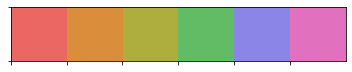

In [5]:
colors = sns.color_palette(np.array([[234,103,99],
[218,142,60],
[174,174,62],
[97,188,101],
[140,133,232],
[225,113,190]])
/255)

sns.palplot(colors)

# colorpalette from iWantHue

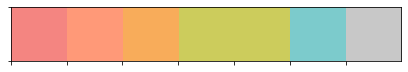

In [6]:
colors_video = sns.color_palette(np.array([[244,133,129],
                                           [255,153,120],
                                            [248,172,90],
                                            [204,204,92],
                                            [204,204,92],
                                            [124, 203, 204],
                                            [200, 200, 200]])
                                            /(255))

sns.palplot(colors_video)

Plot-specific info

In [7]:
sns.set_context("notebook", font_scale=1.5)
sns.set_style("white")
axis_label_fontsize = 24

# Markers for legends of EEG scoring colors
legendMarkersEEG = []
for stage in range(len(stages)):
    legendMarkersEEG.append(plt.Line2D([0],[0], color=colors[stage], marker='o', linestyle='', alpha=0.7))  

Calculate general variables

In [8]:
lightsOffEp = lightsOffSec / epochLength
lightsOnEp = lightsOnSec / epochLength

nBirds = len(birdPaths)

epochLengthPts = epochLength*sr

nStages = len(stagesSleep)

## Load formatted scores

In [9]:
AllScores = {}
for b in range(nBirds):
    bird_name = 'Bird ' + str(b+1)
    file = formatted_scores_path + 'All_scores_' + bird_name + '.csv'
    data = pd.read_csv(file, index_col=0)
    AllScores[bird_name] = data

## Calculate lights off in Zeitgeber time (s and hrs)
Lights on is 0 

In [10]:
lightsOffDatetime = np.array([], dtype='datetime64')
lightsOnDatetime = np.array([], dtype='datetime64')

for b_num in range(nBirds):
    b_name = 'Bird ' + str(b_num+1)
    Scores = AllScores[b_name]
    startDatetime = np.datetime64(Scores.index.values[0])

    # Calc lights off & on using datetime formats
    lightsOffTimedelta = lightsOffSec[b_num].astype('timedelta64[s]')
    lightsOffDatetime = np.append(lightsOffDatetime, startDatetime + lightsOffTimedelta)
    lightsOnTimedelta = lightsOnSec[b_num].astype('timedelta64[s]')
    lightsOnDatetime = np.append(lightsOnDatetime, startDatetime + lightsOnTimedelta)

In [11]:
lightsOffZeit_s = lightsOffSec - lightsOnSec
lightsOffZeit_hr = lightsOffZeit_s / 3600

# Read in motion-detect data

In [12]:
# Function to extract date and time from budgie filename
def get_datetime(s, return_seconds=False):
    # s: string of filename    
    #    Start at second underscore: date and time should follow: BudgieSex_color_YYYY-MM-DD_HH-MM-SS_..."
    c = '_'
    start = [pos for pos, char in enumerate(s) if char == c][1]

    date = s[start+1:start+11]
    hour = s[start+12:start+14]
    minute = s[start+15:start+17]

    if return_seconds:   # if the timestamp in the filename includes seconds 
        seconds = s[start+18:start+20]
        timestamp = np.array([date + 'T' + hour + ':' + minute + ':' + seconds],dtype='datetime64')
    else:
        timestamp = np.array([date + 'T' + hour + ':' + minute],dtype='datetime64')
        
    return(timestamp)

In [13]:
# read motion detect data spanning baseline LD, all LL, and recovery LD
motionDetectDataLD = {}

for b in birds_LL:
    b_name = 'Bird ' + str(b+1)
    # get all motion data
    bird_data = Series([])
    motionLD_path = birdPaths[b] + "Motion detect threshold 0.1/"
    for file in os.listdir(motionLD_path):
        if "motion" in file.lower():
            #file_open = open(motionLD_path+file, 'r')
            #data = read_table(motionLD_path+file, index_col=1, sep=',', lineterminator='\n', header=0)
            data = pd.read_csv(motionLD_path+file, index_col=1, header=0)

            # Get date & time from filename
            file_datetime = get_datetime(file.lower()) + np.timedelta64(6,'s') # Assume 6s latency to start recording

            # Convert frametimes (column 1, in ms) to datetime objects
            ms = np.array(data['timestamp (ms)'])
            frametime = np.array(ms, dtype='timedelta64[ms]')
            file_datetime = np.repeat(file_datetime, len(data.index))
            index_datetime = file_datetime + frametime

            # Add datetime column
            data['Datetime'] = index_datetime

            # append indexed data to time series
            bird_data = bird_data.append(data)

    motionDetectDataLD[b_name] = bird_data

/Users/svcanavan/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


# Plot

In [14]:
# Formatting for figures
figsize = (16,6)

# Moving average colors
color1 = [.8, .8, .8]
color2 = [.5, .5, .5]
color3 = [.3, .3, .3]

# Dot formatting
alpha_main = 0.2
alpha_darker = 0.3

# Line formatting
linewidth = 5
linealpha = .7
marker = 'o'
markersize = 10
err_capsize = 3
err_capthick = 3
elinewidth = 3

# Bar formatting
bar_linewidth = 4

## FIGURE 9D: Heatmap

In [15]:
# Set start time and duration of each plot
plot_starttime = '05:23:00'
plot_duration = np.timedelta64(24, 'h')

# Get time of day for lights on and off
lightsOffTime = lightsOffDatetime.astype('datetime64[s]') - lightsOffDatetime.astype('datetime64[D]')
lightsOnTime  = lightsOnDatetime.astype('datetime64[s]')  - lightsOnDatetime.astype('datetime64[D]')

In [18]:
sns.set_style('white')

smoothing_pd_pts = 10 * 60*30

In [19]:
## Run on Bird 2

birdToRun = 'Bird 2'
b = int(birdToRun[5]) - 1
birdToRunID = b
b_name = birdToRun

In [20]:
All_Resampled_Motiondata = {}
All_Reordered_Motiondata = {}
bird_nDays = []

for b in birds_LL:
    b_name = 'Bird ' + str(b+1)

    data = motionDetectDataLD[b_name]

    # Get list of all the dates in the recording
    times = data['Datetime'].values
    dates = np.unique(times.astype('datetime64[D]'))
    # Add the day before in case of recordings starting in the morning
    day_before = dates[0] - np.timedelta64(1, 'D')
    dates = np.append(day_before, dates)
    bird_nDays.append(dates)

    # Get moving average of data
    smoothed_data = data['Motion (# pixels)'].rolling(smoothing_pd_pts, min_periods=1).mean()

    # Reindex by datetime
    reindexed_data = DataFrame(smoothed_data.values, index=data['Datetime'])

    # Get only data after start of baseline recording
    reindexed_data = reindexed_data[str(scoredNightDatetime[b])::]

    # Resample data
    binSize_min = 10
    resampled_data = reindexed_data.resample(str(binSize_min) + "min").mean()

    # Reshape motion data to a matrix of dates x time

    dates = np.unique(resampled_data.index.values.astype('datetime64[D]'))
    # Add the day before in case of recordings starting in the morning
    day_before = dates[0] - np.timedelta64(1, 'D')
    dates = np.append(day_before, dates)

    for date in dates[1::]:
        # get data
        starttime = date.astype('str') + 'T' + plot_starttime
        stoptime = str(np.datetime64(starttime) + plot_duration)
        row_data = resampled_data[starttime:stoptime]

        # get index as time of day
        time_index = row_data.index.values - date
        time_index_str = time_index.astype('datetime64').astype('str')
        time_of_day = []

        for timestring in time_index_str:
            time_components = timestring.split('T')[1].split(':')
            time_of_day.append(time_components[0] + ':' + time_components[1])

        # reindex using time of day
        row_data_df = DataFrame(row_data.values, index=time_of_day, columns=[date.astype('str')])

        if date == dates[1]:
            reshaped_data = row_data_df
        else:
            # add to reshaped dataframe
            reshaped_data = reshaped_data.join(row_data_df, how='outer')


    # Reorganize data so that it starts with the desired plot time

    morning_data = reshaped_data['05:30'::]
    evening_data = reshaped_data['00:00':'05:20']

    reordered_data = morning_data.append(evening_data)
    
    # Save to dict
    All_Resampled_Motiondata[b_name] = resampled_data
    All_Reordered_Motiondata[b_name] = reordered_data

In [21]:
birds_LL

[1, 2, 3]

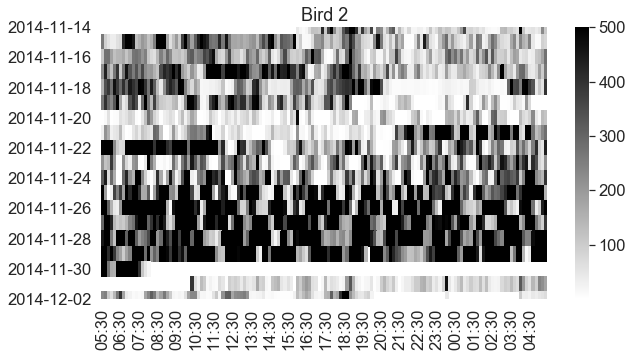

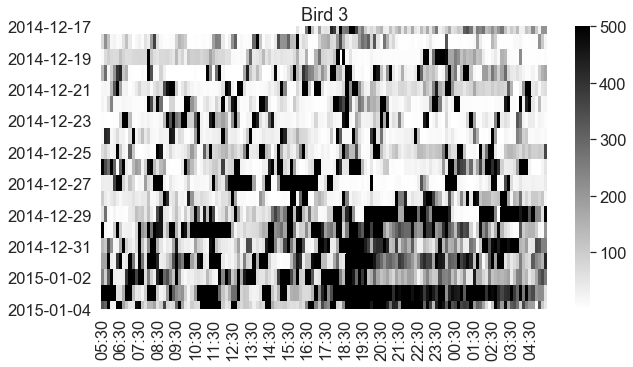

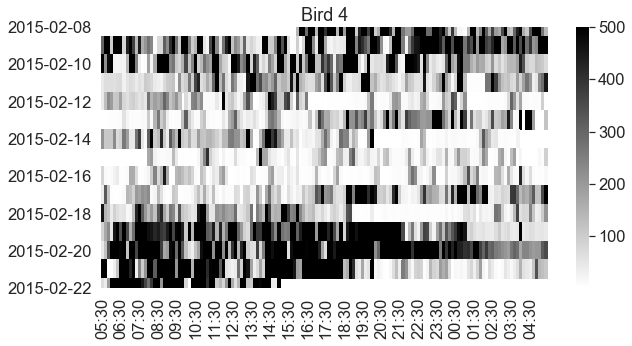

In [23]:
# Plot heatmap
for b in birds_LL:
    b_name = 'Bird ' + str(b+1)

    figsize=(10,.2*len(bird_nDays[b-1]))
    plt.figure(figsize=figsize)

    reordered_data = All_Reordered_Motiondata[b_name]
    sns.heatmap(reordered_data.T, vmax=500, xticklabels=int(60/binSize_min), cmap='gray_r')

    name = saveAsPath + saveAsName + 'd_heatmap_' + b_name
    
    plt.title(b_name)

    if savePlots:
        plt.savefig(name + '.pdf')

## Save heatmap data to csv

In [ ]:
if saveData:
    for b in birds_LL:
        b_name = 'Bird ' + str(b+1)
        reordered_data = All_Reordered_Motiondata[b_name]
        (reordered_data.T).to_csv(saveAsPath + saveAsName + 'b_motiondata_' + b_name + '.csv')

# FIGURE 9E: Lomb-Scargle periodogram

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3663600/#R155

In [24]:
from astropy.stats import LombScargle

In [25]:
# Choose start & end datetimes for periodogram analysis

LD_plot_dates = [[],
                 ['2014-11-14 18:45:00','2014-11-18 18:45:00'], # Bird 2 - LD baseline
                 ['2014-12-29 18:45:00','2015-01-05 18:45:00'], # Bird 3 - LD recovery
                 ['2015-02-18 18:45:00','2015-02-22 18:45:00'], # Bird 4 - LD recovery
                 []]

LL_plot_dates = [[],
                 ['2014-11-18 18:45:00','2014-11-29 18:45:00'], # Bird 2 LL
                 ['2014-12-18 18:45:00','2014-12-29 18:45:00'], # Bird 3 LL
                 ['2015-02-10 05:30:00','2015-02-18 18:45:00'], # Bird 4 LL - include morning because fewer days than other birds
                 []]

/Users/svcanavan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
/Users/svcanavan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
/Users/svcanavan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
/Users/svcanavan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: FutureWarning: The 

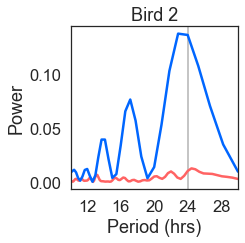

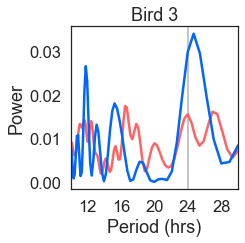

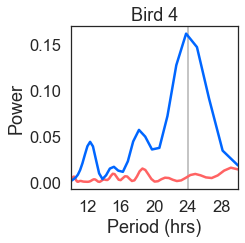

In [26]:
for b in birds_LL:
    b_name = 'Bird ' + str(b+1)
    resampled_data = All_Resampled_Motiondata[b_name]
    
    # LD periodogram
    data = resampled_data[LD_plot_dates[b][0]:LD_plot_dates[b][1]].dropna() # LD baseline
    x = data[0].values
    time_ns = data.index.values - data.index.values[0]
    time_hrs = time_ns.astype('float') / (3600 * 10**9)

    ls = LombScargle(time_hrs, np.ndarray.flatten(x))
    frequency, power = ls.autopower(minimum_frequency=1/30,maximum_frequency=1/10)

    # LL periodogram
    data = resampled_data[LL_plot_dates[b][0]:LL_plot_dates[b][1]].dropna() # LL
    x = data[0].values
    time_ns = data.index.values - data.index.values[0]
    time_hrs = time_ns.astype('float') / (3600 * 10**9)

    ls = LombScargle(time_hrs, np.ndarray.flatten(x))
    LL_frequency, LL_power = ls.autopower(minimum_frequency=1/30,maximum_frequency=1/10)


    # Plot
    plt.figure(figsize=(3,3))
    plt.axvline(24, color = [.7,.7,.7])
    plt.plot(1/LL_frequency, LL_power, color=[1, 99/255, 99/255], lw=linewidth/2) 
    plt.plot(1/frequency, power, color=[0, 102/255, 1], lw=linewidth/2)

    plt.xlim(10,30)
    plt.xticks(np.arange(12,31,4))
    plt.xlabel('Period (hrs)')
    plt.ylabel('Power')
    plt.title(b_name)

    name = saveAsPath + saveAsName + 'e_LSperiodogram_' + b_name

    if savePlots:
        plt.savefig(name + '.pdf')

    if saveData:
        savedata_LD = pd.Series(power, index=frequency)
        savedata_LL = pd.Series(LL_power, index=LL_frequency)

        savedata_LD.to_csv(name + '_LD.csv')
        savedata_LL.to_csv(name + '_LL.csv')